## 4 - Implementing the Q-Learning Algorithm

This final notebook deals with the actual process of creating a reinforcement learning agent for the task of playing Blackjack. There are many types of reinforcement learning algorithms available, and the one I chose to implement in this project is Q-Learning. Q-Learning is a straightforward approach to the process of reinforcement learning, and it essentially increases and decreases the probability of picking a certain action at a certain state based on past rewards.

In [1]:
import sys
sys.path.append('../src')

from environment import BlackjackEnv
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Important Variables

<img src="https://miro.medium.com/v2/resize:fit:1000/format:webp/1*YR4TNCFOxPe0BSxgcdQyIA.png" alt="Blackjack basic strategy chart" /> <br>
*Image credit: [Udacity](https://github.com/udacity/deep-reinforcement-learning/blob/master/cheatsheet/cheatsheet.pdf)*

The first variable required in the Q-Learning process is a `Q_table`. This table is initialized with all zeros, and it represents the learned or accumulated values of all the previous rewards from taking specific actions. The table is 2-dimensional, where the first dimension represents every possible state that can be observed in our environment, and the second dimension represents all our possible actions at every state. Our Blackjack environment has 25 distinct hand totals * 10 distinct dealer up-cards = 250 possible states, and for each state, we have 3 different actions, which are hit, stand, and double down. As a result, our `Q_table` will have dimensions of 250 x 3.

The next variable we need to instantiate is a `prob_table`. This table contains the probabilities of picking every different action at all given environment states, so it will have the same shape as our `Q_table`, which is 250 x 3. These probabilities will all be initialized with 1/3, as each state has 3 possible actions, each with an equal 33.3% chance of being picked.

Now we need to define some rate variables. The first one is `alpha`, which, in all machine learning tasks, is commonly referred to as the "learning rate." This learning rate will dictate how slow or fast our algorithm will learn based off of the rewards that it receives for taking certain actions. This variable is extremely important to the learning process, as a learning rate which is too large might cause our algorithm to overshoot and assign too much importance to a specific action. On the other hand, a learning rate which is too small might cause our model to barely have made any progress by the time we have completed our training. For our purposes, I am choosing to train the algorithm over 10_000_000 `episodes` (rounds of Blackjack), so after some experimentation I have settled on an `alpha` value of 0.001.

Next, we have the `epsilon` value, which is essential for a Q-Learning algorithm. This variable will determine whether our model will "explore" new actions or "exploit" past results at previously visited states. This "explore or exploit" approach is essential in probabilistic situations, as although hitting at a hand total of 20 and receiving an Ace might reward our model with a win, it is self-explanatory that always hitting at a total of 20 would be a bad choice. Thus, the `epsilon` value allows our model to still try actions even if it believes that a different action is better by carefully adjusting the probabilities of each action being selected. However, in this implementation, we will be decaying the `epsilon` value by a set `EPSILON_DECAY` amount until it eventually reaches a `MINIMUM_EPSILON` value. This will allow our model to explore other actions more in the beginning stages of the training, and then exploit and solidify its previously gleaned knowledge in the later stages of training. I have decided to start the `epsilon` value at 0.9999 and decay it by 0.000001 every episode until it reaches a minimum value of 0.5.

The final variable left to define is `gamma`, also known as the discount rate. The approach that I am using for this problem is called a "First Visit Monte Carlo Algorithm" (as opposed to an "Every Visit Monte Carlo Algorithm"). This name implies that during every episode, we will give importance to every consecutive action taken in order to get to the end reward, whether it be a win or loss. Hence, although our algorithm might win a round of Blackjack by hitting 3 times and only receiving a reward on the third hit, there will still be a reward given for both the first and second hitting occurrences too. Conversely, in the "Every Visit" approach, only the current action's rewards are used to calculate the efficacy of an action, leading to no reward being delivered for the first 2 actions in the round. The `gamma` rate will recursively go through each action in the round from start to end and apply a discount to every future reward in the round. This means that although the first hitting action in our example didn't yield the final reward, there will be a discounted reward applied to the first action for being a step along the way towards the winning state.

## Defining One Round

With all our variable definitions, we can first create a function to simulate the running of one round of Blackjack in our environment. We use our `Q_table` and provided "action mask" to pick the best legal action to take every round. Then, we use the probability of the action from the `prob_table` to determine whether we will exploit the best action or explore other possible actions. Finally, we save every tuple of (state, action, reward) triples within a list of episode states and return it.

In [2]:
def run_episode(env, Q_table, prob_table):
    episode_states = []

    state, info = env.reset()

    while not env.done:
        # When the agent has a Blackjack starting hand,
        # there is no action to take and nothing to learn
        if state[0] == 25:
            # Just complete a random action to finish the episode
            _, _, env.done, _, _ = env.step(0)
        else:
            # Get the state from the Q-table by multiplying the player hand
            # number with the second dimension and adding the dealer up-card
            # number, similar to process of flattening (x, y) coordinates
            Q_index = state[0] * env.observation_space[1].n + state[1]

            valid_indices = np.where(info["action_mask"] == 1)[0]  # Find legal actions

            action = np.argmax(Q_table[Q_index, valid_indices])  # Pick best action

            action_prob = prob_table[Q_index][action]

            # Only pick the best action if within probability
            if np.random.rand() < action_prob:
                final_action = action
            else:  # Otherwise keep exploring 
                final_action = np.random.choice(valid_indices[valid_indices != action])

            new_state, reward, _, _, info = env.step(final_action)

            # Add current information to list
            episode_states.append((state, final_action, reward))

            state = new_state
        
    return episode_states

## Variable Update Functions

In order to keep track of and update our 2 tables after each episode, I decided to create a function for each of them. The first is the `update_Q_table()` function, which takes the environment, the list of episode states, and the Q-table, along with the alpha and gamma rates. This function loops through each triple in the episode states, and then loops through each triple from the current state till the end to accumulate the exponentially discounted rewards at each state. Then it calculates what is known as a "temporal difference" (which is the learning rate multiplied by the difference in reward and current Q-value) and adds it to the current Q-value in the Q-table.

The second function is the `update_prob_table()` function, which also takes the environment, the list of episode states, and the Q-table, but also the probability table and the `epsilon` value. This function again loops through the list of states, however, for each state, it finds the best action with the Q-table and increments the probability by (1 - `epsilon`). Finally, it adjusts the other probabilities for that state to make sure all the probabilities still add to 1.

In [3]:
def update_Q_table(env, episode_states, Q_table, alpha, gamma):
    # Loop through every triple in list of states
    for round, (state, action, _) in enumerate(episode_states):
        total_reward = 0  # Initialize reward for current state-action pair

        # Loop through all states from current round to end
        for gamma_exponent, (_, _, round_reward) in enumerate(episode_states[round:]):
            # Add reward gained by each following round multiplied by (discount rate)^round
            total_reward += (gamma ** gamma_exponent) * round_reward

        Q_index = state[0] * env.observation_space[1].n + state[1]
        
        # Increment Q-value in table with temporal difference error
        Q_table[Q_index][action] += alpha * (total_reward - Q_table[Q_index][action])

def update_prob_table(env, episode_states, Q_table, prob_table, epsilon):
    # Loop through every triple in list of states
    for state, _, _ in episode_states:
        Q_index = state[0] * env.observation_space[1].n + state[1]

        action = np.argmax(Q_table[Q_index])  # Find best action

        initial_value = prob_table[Q_index][action]

        # Sets new probability to current probability + 1 - epsilon (upper bound of 1)
        prob_table[Q_index][action] = min(1, prob_table[Q_index][action] + 1 - epsilon)

        # Calculates amount to subtract from other probabilities
        other_prob_change = (prob_table[Q_index][action] - initial_value) / 2

        # Finds right values to subtract from
        mask = np.arange(3)[np.arange(3) != action]

        prob_table[Q_index, mask] -= other_prob_change

In [4]:
def run_training(env, episodes):
    Q_table = np.zeros((env.observation_space[0].n * env.observation_space[1].n, env.action_space.n), dtype=np.float16)
    prob_table = np.full_like(Q_table, 1 / 3, dtype=np.float16)

    alpha = 0.001
    gamma = 0.7
    epsilon = 0.9999
    MINIMUM_EPSILON = 0.5
    EPSILON_DECAY = 0.000001

    for _ in tqdm(range(episodes)):
        episode_states = run_episode(env, Q_table, prob_table)

        epsilon = max(epsilon - EPSILON_DECAY, MINIMUM_EPSILON)

        update_Q_table(env, episode_states, Q_table, alpha, gamma)
        update_prob_table(env, episode_states, Q_table, prob_table, epsilon)

    return Q_table

In [6]:
env = BlackjackEnv()

Q_table = run_training(env, 10000000)

100%|██████████| 10000000/10000000 [03:30<00:00, 47518.37it/s]


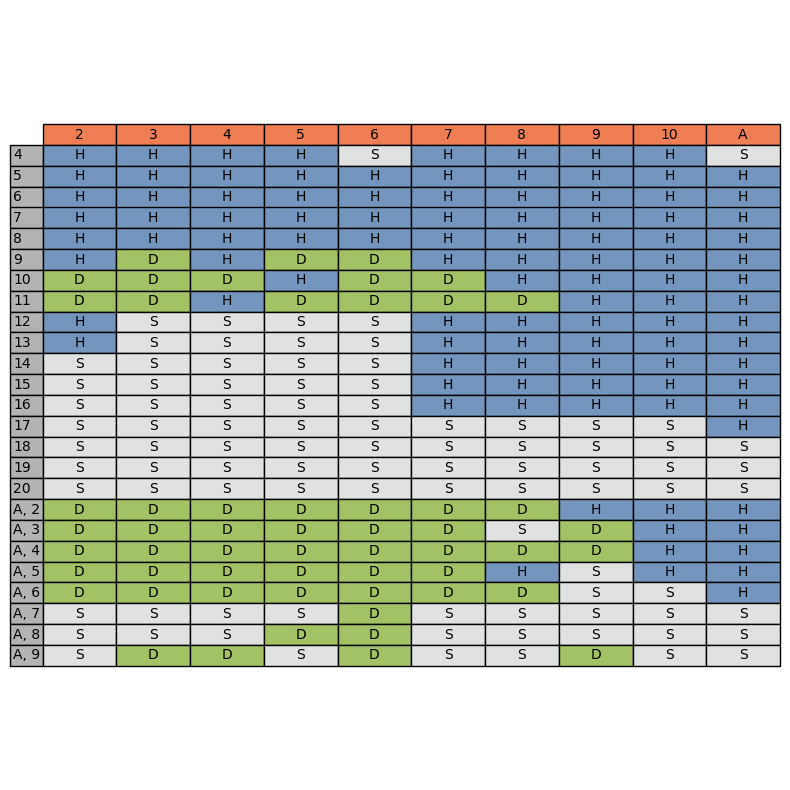

In [7]:
row_labels = list(range(4, 21)) + [f'A, {x}' for x in list(range(2, 10))]
col_labels = list(range(2, 11)) + ['A']

df = pd.DataFrame(index=row_labels, columns=col_labels)
colors = []

action_map = {0: 'H', 1: 'S', 2: 'D'}
color_map = {'H': '#7495BD', 'S': '#E0E1E1', 'D': '#A3C165'}

for i, hand in enumerate(row_labels):
    colors.append([])
    for j, up_card in enumerate(col_labels):
        action = action_map[np.argmax(Q_table[i * 10 + j])]
        df.loc[hand, up_card] = action
        colors[i].append(color_map[action])

fig, ax = plt.subplots(figsize=(8,8))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(
    cellText=df.values,
    cellColours=colors,
    cellLoc='center',
    colLabels=col_labels,
    colColours=['#EF7E54' for _ in range(len(col_labels))],
    rowLabels=row_labels,
    rowColours=['#B3B3B3' for _ in range(len(row_labels))],
    loc='center'
)

fig.tight_layout()
plt.show()

In [8]:
def test_avg_winnings(env):
    total_rewards = 0
    episodes = 10000000

    for _ in tqdm(range(episodes)):
        state, info = env.reset()

        while env.done == False:
            if state[0] == 25:
                _, reward, _, _, _ = env.step(1)
                total_rewards += reward
            else:
                Q_index = state[0] * env.observation_space[1].n + state[1]
                action = np.argmax(Q_table[Q_index, np.where(info["action_mask"] == 1)[0]])

                new_state, reward, _, _, info = env.step(action)
                state = new_state
                total_rewards += reward
            
    avg_reward = total_rewards / episodes
    return f'{avg_reward * 100:.2f}'

In [9]:
regular_env = BlackjackEnv()
higher_payout_env = BlackjackEnv(higher_payout=True)

print('For a 100 dollar bet:')
print('Average win/loss in a 1:1 blackjack payout is', test_avg_winnings(regular_env))
print('Average win/loss in a 3:2 blackjack payout is', test_avg_winnings(higher_payout_env))

For a 100 dollar bet:


100%|██████████| 10000000/10000000 [01:45<00:00, 95145.61it/s]


Average win/loss in a 1:1 blackjack payout is -5.59


100%|██████████| 10000000/10000000 [01:44<00:00, 95761.09it/s]

Average win/loss in a 3:2 blackjack payout is -0.53
